# Qubit chains "punched" by measurements

In this work I use the Qiskit BasicAer simulator to simulate in an ideal noise-free quantum computer a chain of 3 qubits where one of the qubits being subject to periodic measurements. More specifically, with the concept of *quantum trajectories* alongside Qiskit I show that periodic measurements tend to stabilize the energy of the chain over time. A brief (but sufficient) explanation of all these concepts is given in the text.

This is the very start of my PhD research project and I intend to constantly update it over time.

The investigation of how exactly the energy of qubit chains vary due to measurements may contribute to the general problem of determining new techniques for the manipulation of energy exchanges within quantum processors, while serving as a new and exciting way for me to test and deepen my abilities with Qiskit.

## 1. Outline of the project

Being more specific about what was mentioned above, the idea is to repeat the following instructions several times:

1. The chain evolves a time $t$.
2. One of the qubits of the chain is measured.
3. The expectation value $E$ of the energy of the chain is computed.

It is useful to call a single implementation of these three instructions a __step__ and a sequence of $N$ integer steps a __trajectory__.

This idea is similar to what happens in the well known *Ising model* for ferromagnetic materials. In this last model, however, a spin-flip is induced on a chain of spins as the net effect of an external magnetic field, whereas in our case the intention is to "punch" a qubit of the chain with a measurement. 

Two types of chain are then considered: __open chains__ and __closed chains__. In the former type, the last qubit of the chain is not allowed to interact with the first, and in the later type, the last qubit of the chain is allowed to interact with the first.

For simplicity let us restrict for now to a chain of 3 qubits only. To the end of implementing the time-evolution of instruction 1 and of calculating the mean energy of the system in instruction 3, I took the Hamiltonian operators

\begin{equation}
    \begin{split}
        H_{open} &= - \frac{J_1}{2} I \otimes X \otimes X - \frac{J_2}{2} Z \otimes Z \otimes I\\
        H_{closed} &=  - \frac{J_1}{2} I \otimes X \otimes X - \frac{J_2}{2} Z \otimes Z \otimes I - \frac{J_3}{2} X \otimes I \otimes X
    \end{split}
\end{equation}

where $J_1$, $J_2$ and $J_3$ are constants. Our unitary time evolution operator is of course, $U = exp\{ - i H T \}$ and $E = \langle \psi(t) |H| \psi(t) \rangle$, where $|\psi(t)\rangle$ is the state of the system at time $t$.

Let us implement these operators in Qiskit, choosing specific values for the coupling constants and for the evolution time $t$.

In [36]:
import numpy as np
from qiskit.opflow import I, X, Y, Z

J_1 = J_2 = J_3 = -2.0

t = np.pi/5

H_open = - (J_1/2.0) * (I ^ X ^ X) - (J_2/2.0) * (Z ^ Z ^ I)
H_closed = - (J_1/2.0) * (I ^ X ^ X) - (J_2/2.0) * (Z ^ Z ^ I) - (J_3/2.0) * (X ^ I ^ X)

U_open = (H_open*t).exp_i()
U_closed = (H_closed*t).exp_i()

We note that these were simple choices for H, but many others could be explored as well.

For the sake of imagination, we draw a sample circuit of 4 steps to illustrate or process choosing qubit 1 of the chain as the qubit to be measured. After each measurement indicated in the figure the mean energy of the system is calculated.

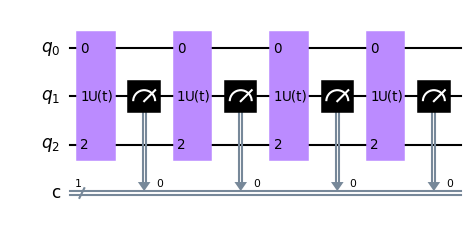

In [30]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

q = QuantumRegister(3, 'q')
c = ClassicalRegister(1, 'c')

qc = QuantumCircuit(q, c)

for i in range(4):
    qc.unitary(U_open, q, label = 'U(t)')
    qc.measure(q[1], c[0])

qc.draw('mpl', scale = 0.75)

## 2. Quantum trajectories

Because the outcome of each measurement is inherently probabilistic, we expect the system to behave very differently along different trajectories. For example, in a trajectory of, say, 4 steps, the set of outcomes of the measurements on the chosen qubit of the chain may be $\{|0\rangle, |1\rangle, |1\rangle, |0\rangle\}$,  $\{|1\rangle, |0\rangle, |1\rangle, |1\rangle\}$,  $\{|1\rangle, |0\rangle, |0\rangle, |0\rangle\}$, etc. We shall then, in this case, obtain a different set of energy expectation values for each possible trajectory the system may undergo

However, what I wish to investigate is the *general* behavior of the system. This means that we may simply run a sufficiently large number of trajectories, calculate $E$ at each step of each trajectory, and in the end calculate the mean value of $E$ for each step. For example, we may run 1000 trajectories and obtain at step 3 the energies $E_1^3$, $E_2^3$, $E_3^3$, ... for each one with probabilities $p_1^3$, $p_2^3$, $p_3^3$ ... . Of course $p_i^3 =$ #times that $E_i^3$ occurred/1000. Finally, we can calculate the mean value of $E$ at step 3:

\begin{equation}
    E = \sum_i p_i^3 E_i^3.
\end{equation}

Because in a real experiment all energies would fluctuate around the mean value, this is a satisfactory result for the general behavior of the system at step 3. 

I indend to apply this procedure to all steps.

## 3. Simulating state vectors with BasicAer

As denoted above, a simple way to calculate expectation values is to use the state vector that describes our quantum circuit, which can be easily obtained with the Qiskit BasicAer statevector simulator. It is convenient to create the following function that receives a quantum circuit as argument and returns its state vector:

In [31]:
from qiskit import BasicAer, transpile
from qiskit.quantum_info import Statevector

backend = BasicAer.get_backend('statevector_simulator')

def simulate_statevector(Q_circuit):
    tqc = transpile(Q_circuit, backend)
    job = backend.run(tqc)
    result = job.result()
    return Statevector(result.get_statevector(tqc, 4))

If the circuit cointains no measurement the `Statevector` class of `qiskit.quantum_info` does not require a simulator to work. However, because circuits with measurements represent real experiments, it is necessary to use a simulator in this case.

As a simple illustration (that has nothing to do with the project itself) let's obtain the state vector of the circuit that implements the bell state $(|00\rangle + |11\rangle)/\sqrt{2}$ and measures qubit 0.

In [32]:
bell_qc = QuantumCircuit(2, 1)

bell_qc.h(0)
bell_qc.cx(0, 1)

bell_qc.measure(0, 0)

psi = simulate_statevector(bell_qc)

psi.draw('latex')

<IPython.core.display.Latex object>

## 4 Running the program

We are now in a position to run the simulation proposed in §1. As said in the introduction, the energy of the system stabilizes over time. This is confirmed by the plots after each program.

### 4.1 Open chain

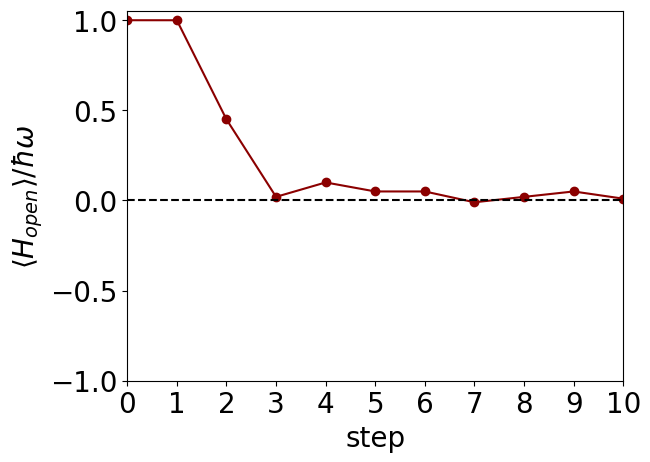

In [58]:
num_trajectories = 200
num_steps = 10

mean_energies = np.zeros(num_steps + 1) # Array to store mean energies after all trajectories

for trajectory in range(num_trajectories):
    
    # Registers
    qr = QuantumRegister(3, 'q')
    cr = ClassicalRegister(1, 'c')
    
    # Creating circuit
    qc = QuantumCircuit(qr, cr)
    
    # Array to store energies of this specific trajectory
    energies = []
    energies.append(simulate_statevector(qc).expectation_value(H_open).real) # Appending initial energy
    
    for step in range(num_steps):
        
        qc.unitary(U_open, qr, 'U(t)') # Evolving the circuit
        
        psi = simulate_statevector(qc) # Getting state vector
        
        qc.measure(qr[1], cr[0]) # Measuring
        
        energies.append(psi.expectation_value(H_open).real) # Getting energy
        
    for step in range(num_steps + 1):
        mean_energies[step] += energies[step]/num_trajectories
        
# Making a plot
from matplotlib.pyplot import plot, show, xlim, ylim, xlabel, ylabel, title, savefig, xticks, yticks

plot(range(num_steps + 1), mean_energies, marker = 'o', color = 'darkred')
plot(range(num_steps + 1), np.zeros(num_steps + 1), linestyle = 'dashed', color = 'black')

# Changing plot style
xlim(0,num_steps)
#ylim(-1.1,1.1) # Limiting the y-range of the plot
xlabel(r'step', size = 20) # Labeling the x-axis
ylabel(r'$\langle H_{open} \rangle / \hbar\omega$', size = 20) # Labeling the y-axis
xticks(range(num_steps+1), size = 20)
yticks([-1.0, -0.5, 0.0, 0.50, 1.0], size = 20)

show()

### 4.2 Closed chain

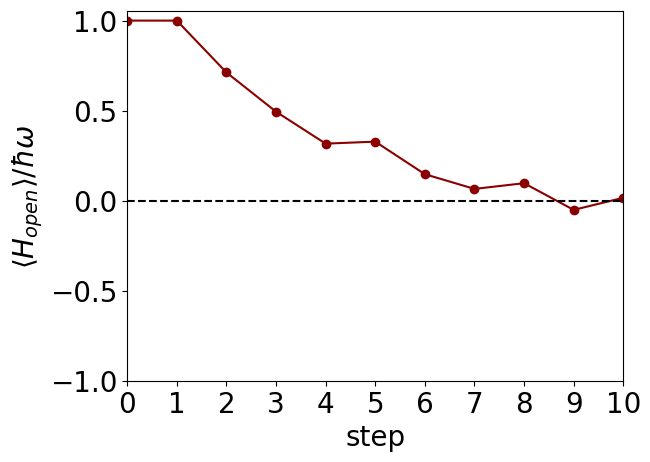

In [59]:
num_trajectories = 200
num_steps = 10

mean_energies = np.zeros(num_steps + 1) # Array to store mean energies after all trajectories

for trajectory in range(num_trajectories):
    
    # Registers
    qr = QuantumRegister(3, 'q')
    cr = ClassicalRegister(1, 'c')
    
    # Creating circuit
    qc = QuantumCircuit(qr, cr)
    
    # Array to store energies of this specific trajectory
    energies = []
    energies.append(simulate_statevector(qc).expectation_value(H_open).real) # Appending initial energy
    
    for step in range(num_steps):
        
        qc.unitary(U_closed, qr, 'U(t)') # Evolving the circuit
        
        psi = simulate_statevector(qc) # Getting state vector
        
        qc.measure(qr[1], cr[0]) # Measuring
        
        energies.append(psi.expectation_value(H_closed).real) # Getting energy
        
    for step in range(num_steps + 1):
        mean_energies[step] += energies[step]/num_trajectories
        
# Making a plot
from matplotlib.pyplot import plot, show, xlim, ylim, xlabel, ylabel, title, savefig, xticks, yticks

plot(range(num_steps + 1), mean_energies, marker = 'o', color = 'darkred')
plot(range(num_steps + 1), np.zeros(num_steps + 1), linestyle = 'dashed', color = 'black')

# Changing plot style
xlim(0,num_steps)
#ylim(-1.1,1.1) # Limiting the y-range of the plot
xlabel(r'step', size = 20) # Labeling the x-axis
ylabel(r'$\langle H_{open} \rangle / \hbar\omega$', size = 20) # Labeling the y-axis
xticks(range(num_steps+1), size = 20)
yticks([-1.0, -0.5, 0.0, 0.50, 1.0], size = 20)

show()